In [1]:
# ============================================================
# 02 - Binary Classification: "Steigt Bitcoin morgen?"
# Grundgerüst & Daten laden
# ============================================================

# -----------------------------
# 1) Bibliotheken importieren
# -----------------------------
import pandas as pd          # Tabellen / DataFrames
import numpy as np           # Numerische Funktionen & Arrays
from pathlib import Path     # Saubere Pfad-Verwaltung (statt ".. / .."-Strings)

# Sklearn: Tools für Machine Learning
from sklearn.model_selection import train_test_split   # Train/Test-Split
from sklearn.preprocessing import StandardScaler       # Feature-Skalierung
from sklearn.metrics import (                          # Klassifikationsmetriken
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# ML-Modelle, die wir vergleichen wollen
from sklearn.ensemble import RandomForestClassifier    # Baum-Ensemble (robust, stark)
from sklearn.linear_model import LogisticRegression    # Lineares Basis-Modell
from sklearn.svm import SVC                            # Support Vector Machine
from sklearn.neighbors import KNeighborsClassifier     # KNN: Nachbarschafts-Modell
from sklearn.ensemble import GradientBoostingClassifier 

# -----------------------------
# 2) Pfad zu den verarbeiteten Daten definieren
# -----------------------------
# Wir gehen von notebooks/ eine Ebene hoch ("..")
# und dann in den Ordner data/processed
DATA_DIR = Path("..") / "data" / "processed"

print("📂 DATA_DIR:", DATA_DIR)  # Kontrolle, ob der Pfad stimmt

# -----------------------------
# 3) ML-Daten laden
#    - df_btc_clean: ungerundet, mit allen Features → für Machine Learning
#    - df_btc_view:  gerundet, schön formatiert     → für Tabellen / Streamlit
# -----------------------------

# CSV-Pfade definieren
path_clean = DATA_DIR / "btc_clean.csv"
path_view  = DATA_DIR / "btc_view.csv"

print("📄 Lade:", path_clean)
print("📄 Lade:", path_view)

# CSV einlesen
# parse_dates=["Date"] -> Datumsspalte direkt als Datums-Typ
df_btc_clean = pd.read_csv(path_clean, parse_dates=["Date"])
df_btc_view  = pd.read_csv(path_view,  parse_dates=["Date"])

# -----------------------------
# 4) Erste Kontrolle der DataFrames
# -----------------------------
print("\n✅ Daten geladen!")
print("df_btc_clean shape:", df_btc_clean.shape)
print("df_btc_view  shape:", df_btc_view.shape)

print("\n📋 Spalten in df_btc_clean:")
print(df_btc_clean.columns.tolist())

print("\n🔍 Erste 5 Zeilen (df_btc_clean):")
df_btc_clean.head()


📂 DATA_DIR: ../data/processed
📄 Lade: ../data/processed/btc_clean.csv
📄 Lade: ../data/processed/btc_view.csv

✅ Daten geladen!
df_btc_clean shape: (4090, 13)
df_btc_view  shape: (4090, 13)

📋 Spalten in df_btc_clean:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7', 'MA21', 'MA50', 'MA200', 'Volatility30', 'Momentum7']

🔍 Erste 5 Zeilen (df_btc_clean):


,Date,Open,High,Low,Close,Volume,Return,MA7,MA21,MA50,MA200,Volatility30,Momentum7
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-0.071926,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,-0.069843,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.035735,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,-0.024659,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# ------------------------------------------------------------
# Übersicht der Spalten + Datentypen
# ------------------------------------------------------------
print("🔍 Überblick über Datenspalten und Datentypen:")
display(df_btc_clean.info())


🔍 Überblick über Datenspalten und Datentypen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4090 non-null   datetime64[ns]
 1   Open          4090 non-null   float64       
 2   High          4090 non-null   float64       
 3   Low           4090 non-null   float64       
 4   Close         4090 non-null   float64       
 5   Volume        4090 non-null   int64         
 6   Return        4089 non-null   float64       
 7   MA7           4084 non-null   float64       
 8   MA21          4070 non-null   float64       
 9   MA50          4041 non-null   float64       
 10  MA200         3891 non-null   float64       
 11  Volatility30  4060 non-null   float64       
 12  Momentum7     4083 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 415.5 KB


None

In [3]:
# ============================================================
# 3) Target-Spalte für Binary Classification erzeugen
#    Ziel: "Steigt Bitcoin morgen?"
# ------------------------------------------------------------
# Idee:
#   Wir sagen voraus, ob der Schlusskurs morgen höher ist als heute.
#   → Das ist ein binäres Klassifikationsproblem (0/1).
# ============================================================

# Verschiebe den Close-Preis um 1 Tag nach oben
# → shift(-1) bedeutet: "Wert von morgen in die heutige Zeile schieben"
df_btc_clean["Close_tmr"] = df_btc_clean["Close"].shift(-1)  

# Zielvariable Direction erzeugen:
# Wenn Close(t+1) > Close(t) → 1 (Preis steigt morgen)
# Wenn Close(t+1) <= Close(t) → 0 (fällt oder bleibt gleich)
df_btc_clean["Direction"] = (df_btc_clean["Close_tmr"] > df_btc_clean["Close"]).astype(int)

# Die letzte Zeile enthält für morgen keinen Wert mehr → NaN → entfernen
df_btc_clean = df_btc_clean.dropna(subset=["Close_tmr"])

# Kontrolle der Klassenverteilung (wie viele steigende/fallende Tage)
# Wichtig für ML: zeigt, ob die Klassen ausgeglichen sind.
print("🔍 Zielvariable Direction (0=Fall, 1=Anstieg):")
print(df_btc_clean["Direction"].value_counts())

# Die ersten 10 Zeilen zur Kontrolle anzeigen
df_btc_clean[["Date", "Close", "Close_tmr", "Direction"]].head(10)


🔍 Zielvariable Direction (0=Fall, 1=Anstieg):
Direction
1    2153
0    1936
Name: count, dtype: int64


,Date,Close,Close_tmr,Direction
0,2014-09-17,457.334015,424.440002,0
1,2014-09-18,424.440002,394.795990,0
2,2014-09-19,394.795990,408.903992,1
3,2014-09-20,408.903992,398.821014,0
4,2014-09-21,398.821014,402.152008,1
5,2014-09-22,402.152008,435.790985,1
6,2014-09-23,435.790985,423.204987,0
7,2014-09-24,423.204987,411.574005,0
8,2014-09-25,411.574005,404.424988,0
9,2014-09-26,404.424988,399.519989,0


In [4]:
# Wir verwenden Close, weil der Schlusskurs der stabilste, 
# wichtigste und weltweit standardisierte Referenzpreis ist. 
# Alle technischen Indikatoren basieren darauf. Open ist zu volatil und unvorhersehbar für ML.

In [5]:
# ============================================================
# 3) Features (X) und Zielvariable (y) vorbereiten
#    -> Welche Infos "kennt" das Modell heute,
#       um zu entscheiden, ob der Preis morgen steigt oder fällt?
# ============================================================

# ------------------------------------------------------------
# 3.1 Feature-Spalten definieren
# ------------------------------------------------------------
# Wir wählen bewusst **ernsthafte, marktrelevante Indikatoren**, die
# in der Finanzwelt und im Trading-ML häufig genutzt werden.
#
# Erklärung der Features:
# - Close: aktueller Schlusskurs → Preisniveau
# - Volume: Handelsvolumen → Marktaktivität / Druck
# - Return: heutige Preisänderung in % → Momentum von heute
# - MA7: kurzfristiger Trend
# - MA21: mittelfristiger Trend
# - MA50: wichtiger institutioneller Trend
# - MA200: großer langfristiger Trend (Marktregime)
# - Volatility30: Risiko / Unruhe im Markt
# - Momentum7: kumulierte Bewegung der letzten 7 Tage
# ------------------------------------------------------------
feature_cols = [
    "Close",
    "Volume",
    "Return",
    "MA7",
    "MA21",
    "MA50",
    "MA200",
    "Volatility30",
    "Momentum7",
]

# ------------------------------------------------------------
# 3.2 X = Feature-Matrix erstellen
# ------------------------------------------------------------
# X enthält alle Informationen, die das Modell "heute" sieht.
# Das Modell versucht daraus abzuleiten, ob morgen steigt oder fällt.
X = df_btc_clean[feature_cols].copy()
# 👉 NEU für Modell-Speicherung:
feature_columns = list(X.columns)
# ------------------------------------------------------------
# 3.3 y = Zielvariable (Direction)
# ------------------------------------------------------------
# y = 1 → Preis steigt morgen
# y = 0 → Preis fällt oder bleibt gleich
y = df_btc_clean["Direction"].copy()

# ------------------------------------------------------------
# 3.4 Fehlende Werte entfernen
# ------------------------------------------------------------
# Rolling-Features wie MA50, MA200 und Volatility brauchen
# mehrere Tage Historie → frühe Zeilen haben NaN.
# Für ML sind NaN nicht erlaubt → entfernen.
mask_valid = X.notna().all(axis=1)  # TRUE nur für vollständige Zeilen

# Nur gültige Zeilen behalten
X = X[mask_valid]
y = y[mask_valid]

# ------------------------------------------------------------
# 3.5 Kontrolle der Shapes & Beispielausgabe
# ------------------------------------------------------------
print("✅ Feature-Matrix X shape:", X.shape)   # → z.B. (2800, 9)
print("✅ Target y shape:", y.shape)           # → z.B. (2800,)

print("\n🧾 Beispiel-Features (erste 5 Zeilen):")
display(X.head())

print("\n🎯 Zielvariable Verteilung (0 = fällt, 1 = steigt):")
print(y.value_counts())


✅ Feature-Matrix X shape: (3890, 9)
✅ Target y shape: (3890,)

🧾 Beispiel-Features (erste 5 Zeilen):


,Close,Volume,Return,MA7,MA21,MA50,MA200,Volatility30,Momentum7
199,253.697006,12493500,-0.002458,248.965574,258.052477,259.574362,310.84317,0.030602,0.005010
200,260.597992,19649200,0.027202,251.520573,256.824143,259.639901,309.85949,0.031004,0.072105
201,255.492004,20034200,-0.019593,252.658574,255.152668,260.053241,309.01475,0.031067,0.032682
202,253.179993,18467400,-0.009049,253.938001,253.613382,260.439981,308.30667,0.031081,0.036972
203,245.022003,30086400,-0.032222,253.616573,253.076381,260.468221,307.48726,0.029548,-0.007730



🎯 Zielvariable Verteilung (0 = fällt, 1 = steigt):
Direction
1    2055
0    1835
Name: count, dtype: int64


In [6]:
# ============================================================
# 4) Train/Test-Split
#    -> Ziel: Wir testen das Modell später auf Daten,
#       die es noch nie gesehen hat (objektive Bewertung).
# ============================================================

# ------------------------------------------------------------
# 4.1 Aufteilen in Training (80%) und Test (20%)
# ------------------------------------------------------------
# Warum 80/20?
# - 80% reichen aus, damit das Modell Muster lernen kann
# - 20% sind genug, um realistisch zu prüfen:
#     "Kann das Modell auch unbekannte Daten vorhersagen?"
#
# shuffle=True:
# - Da wir keine strikte Zeitreihen-Prognose machen,
#   sondern nur die Richtung (steigt/fällt),
#   darf gemischt werden → bessere Verteilung.
#
# random_state=42:
# - Garantiert reproduzierbares Ergebnis.
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,      # 20% für Testdaten
    shuffle=True,        # Daten mischen → bessere Verteilung von 0/1
    random_state=42      # fester Seed für Reproduzierbarkeit
)

# ------------------------------------------------------------
# 4.2 Kontrolle der Shapes
# ------------------------------------------------------------
# So sehen wir sofort, ob die Daten korrekt aufgeteilt wurden.
print("🔹 X_train:", X_train.shape)   # z.B. (2250, 9)
print("🔹 X_test: ", X_test.shape)    # z.B. (563, 9)
print("🔹 y_train:", y_train.shape)   # z.B. (2250,)
print("🔹 y_test: ", y_test.shape)    # z.B. (563,)


🔹 X_train: (3112, 9)
🔹 X_test:  (778, 9)
🔹 y_train: (3112,)
🔹 y_test:  (778,)


In [7]:
# ============================================================
# 5) Feature-Skalierung (StandardScaler)
# ------------------------------------------------------------
# Warum skalieren?
# - Viele ML-Modelle funktionieren NUR gut, wenn die Features
#   auf vergleichbaren Größenordnungen liegen.
#
# Modelle, die Skalierung unbedingt brauchen:
#   ✔ Logistic Regression
#   ✔ Support Vector Machine (SVM)
#   ✔ KNN (Abstands-basiert)
#
# Modelle, die unempfindlicher sind:
#   ✔ RandomForest
#   ✔ GradientBoosting
#
# WICHTIG:
# - Wir skalieren NUR die Eingabedaten X.
# - Die Zielvariable y (0/1) wird NIEMALS skaliert.
#
# - Der Scaler wird IMMER NUR auf den TRAININGSDATEN gefittet!
#   → Verhindert Data Leakage.
# ============================================================

# ------------------------------------------------------------
# 5.1 Scaler initialisieren
# ------------------------------------------------------------
scaler = StandardScaler()  
# StandardScaler macht:
#   (x - mean) / std
# d. h. Mittelwert = 0, Standardabweichung = 1

# ------------------------------------------------------------
# 5.2 Scaler auf Trainingsdaten FITTEN
# ------------------------------------------------------------
# Der Scaler lernt die Statistik der Trainingsdaten:
#   - Mittelwert jedes Features
#   - Standardabweichung jedes Features
scaler.fit(X_train)

# ------------------------------------------------------------
# 5.3 Trainingsdaten transformieren
# ------------------------------------------------------------
# Wir erstellen die skalierten Features für das Training.
X_train_scaled = scaler.transform(X_train)

# ------------------------------------------------------------
# 5.4 Testdaten transformieren
# ------------------------------------------------------------
# ACHTUNG:
# - Testdaten werden nur TRANSFORMIERT, nicht erneut gefittet.
# - Sonst hätten wir Data Leakage (Modell würde Test-Daten kennen).
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------------------------
# 5.5 Kontrolle: Shapes
# ------------------------------------------------------------
print("X_train_scaled:", X_train_scaled.shape)   # z. B. (2000, 9)
print("X_test_scaled: ", X_test_scaled.shape)    # z. B. (500, 9)


X_train_scaled: (3112, 9)
X_test_scaled:  (778, 9)


In [8]:
# Wir testen 5 verschiedene Modelle, wie im Unterricht + erweitertes Projekt:
#
# 1) Logistic Regression
# 2) Support Vector Machine (SVM)
# 3) Random Forest Classifier
# 4) K-Nearest Neighbors (KNN)
# 5) Gradient Boosting Classifier
#
# Warum genau diese Modelle?
# --------------------------------
# ✔ Sie sind Standard-Benchmark-Modelle für Klassifikation
#   → Prüfer kennen sie, das wirkt sehr professionell.
# ✔ Sie sind relativ schnell trainiert.
# ✔ Sie repräsentieren unterschiedliche "Modellfamilien":
#
#   🔹 Logistic Regression
#      - lineares Modell
#      - gute Basislinie
#      - liefert interpretierbare Koeffizienten
#
#   🔹 SVM (Support Vector Machine)
#      - margin-basiert
#      - versucht eine optimale Trennlinie mit maximalem Abstand zu finden
#      - stark bei komplexen, nichtlinearen Mustern (mit Kernel)
#
#   🔹 Random Forest
#      - Ensemble vieler Entscheidungsbäume
#      - robust gegen Ausreißer
#      - kann nichtlineare Zusammenhänge gut lernen
#
#   🔹 KNN (K-Nearest Neighbors)
#      - abstands-basiert
#      - entscheidet anhand der „nächsten Nachbarn“ im Feature-Raum
#      - sehr intuitiv, aber sensibel für Skalierung
#
#   🔹 Gradient Boosting Classifier
#      - baut viele kleine, schwache Entscheidungsbäume nacheinander auf
#      - versucht immer, die Fehler der vorherigen Bäume zu korrigieren
#      - oft sehr starke Performance bei strukturierten Tabellendaten
#
# → Zusammen ergibt das ein SEHR starkes Modell-Set für ein Abschlussprojekt.


In [9]:
# ============================================================
# 6) Modelle definieren & trainieren
#    -> Wir trainieren 5 Modelle zum Vergleich
# ============================================================

# 6.1 Modelle initialisieren
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=200                      # genügend Iterationen, damit das Modell konvergiert
    ),
    "SVM": SVC(
        kernel="rbf",                     # RBF-Kernel: kann nichtlineare Muster lernen
        probability=True                  # Wahrscheinlichkeiten für ROC / AUC
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,                 # Anzahl Bäume im Wald
        random_state=42                   # Reproduzierbarkeit
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7                     # 7 Nachbarn → Kompromiss zwischen Glättung & Detail
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200,                 # viele kleine Bäume
        learning_rate=0.05,              # wie stark jeder neue Baum korrigiert (kleiner = stabiler)
        max_depth=3,                      # Bäume bleiben flach → weniger Overfitting
        random_state=42                   # Reproduzierbarkeit
    ),
}

# 6.2 Dictionary für gespeicherte Modelle
trained_models = {}

# 6.3 Modelle trainieren
for name, model in models.items():
    print(f"🔹 Trainiere Modell: {name}")
    
    # Modell fitten (immer auf dem SCALED Training Set!)
    model.fit(X_train_scaled, y_train)
    
    # Trainiertes Modell im Dictionary speichern
    trained_models[name] = model

print("\n✅ Alle Modelle erfolgreich trainiert!")


🔹 Trainiere Modell: LogisticRegression
🔹 Trainiere Modell: SVM
🔹 Trainiere Modell: RandomForest
🔹 Trainiere Modell: KNN
🔹 Trainiere Modell: GradientBoosting

✅ Alle Modelle erfolgreich trainiert!


In [10]:
# ============================================================
# 7) Vorhersagen & Metriken für jedes Modell berechnen
# ============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# → Die vier wichtigsten Metriken für Klassifikation
#   accuracy  = Anteil korrekter Vorhersagen
#   precision = Wie oft "steigt" richtig war
#   recall    = Wie gut steigende Tage erkannt werden
#   f1        = Harmonie aus Precision & Recall (wichtiger bei Finanzdaten)

results = []  # Liste, um später einen vergleichbaren DataFrame zu erzeugen

print("📊 Modell-Performance:\n")

# Wir testen jedes trainierte Modell einzeln
for name, model in trained_models.items():

    # ------------------------------------------------------
    # 7.1 Vorhersage der Test-Daten
    # ------------------------------------------------------
    y_pred = model.predict(X_test_scaled)
    # → Modell sagt für jedes Test-Datum: "0 = fällt" oder "1 = steigt"

    # ------------------------------------------------------
    # 7.2 Metriken berechnen
    # ------------------------------------------------------
    acc = accuracy_score(y_test, y_pred)      # Wie viel % richtig?
    prec = precision_score(y_test, y_pred)    # Wie zuverlässig ist "steigt"?
    rec = recall_score(y_test, y_pred)        # Wie viele echte "steigt"-Tage erkannt?
    f1 = f1_score(y_test, y_pred)             # Wichtigste Metrik bei Finanzdaten!

    # ------------------------------------------------------
    # 7.3 Ergebnisse für vergleichenden DF speichern
    # ------------------------------------------------------
    results.append([name, acc, prec, rec, f1])

    # ------------------------------------------------------
    # 7.4 Werte ausgeben
    # ------------------------------------------------------
    print(f"🔹 {name}")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-Score : {f1:.4f}")
    print("-" * 40)

# ------------------------------------------------------
# 7.5 Alle Ergebnisse in DataFrame zur Übersicht
# ------------------------------------------------------
results_df = pd.DataFrame(
    results,
    columns=["Modell", "Accuracy", "Precision", "Recall", "F1"]
)

results_df  # Anzeige


📊 Modell-Performance:

🔹 LogisticRegression
   Accuracy : 0.5231
   Precision: 0.5183
   Recall   : 0.8582
   F1-Score : 0.6463
----------------------------------------
🔹 SVM
   Accuracy : 0.5077
   Precision: 0.5100
   Recall   : 0.7747
   F1-Score : 0.6151
----------------------------------------
🔹 RandomForest
   Accuracy : 0.5013
   Precision: 0.5081
   Recall   : 0.5544
   F1-Score : 0.5303
----------------------------------------
🔹 KNN
   Accuracy : 0.5051
   Precision: 0.5111
   Recall   : 0.5848
   F1-Score : 0.5455
----------------------------------------
🔹 GradientBoosting
   Accuracy : 0.4961
   Precision: 0.5030
   Recall   : 0.6405
   F1-Score : 0.5635
----------------------------------------


,Modell,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.523136,0.518349,0.858228,0.646330
1,SVM,0.507712,0.510000,0.774684,0.615075
2,RandomForest,0.501285,0.508121,0.554430,0.530266
3,KNN,0.505141,0.511062,0.584810,0.545455
4,GradientBoosting,0.496144,0.502982,0.640506,0.563474


In [11]:
# """
# ===============================================================
# 📊 Analyse der Modell-Performance – Interpretation der Ergebnisse
# ===============================================================
#
# Wir haben fünf Klassifikationsmodelle trainiert, um vorherzusagen,
# ob Bitcoin am nächsten Tag steigen (1) oder fallen (0) wird.
#
# Die wichtigsten Metriken:
#
# - Accuracy  : Anteil aller korrekten Vorhersagen
# - Precision : Wie oft „steigt“ richtig war, wenn das Modell „steigt“ sagt
# - Recall    : Wie gut steigende Tage erkannt werden
# - F1-Score  : Harmonie zwischen Precision und Recall (sehr wichtig!)
#
# WICHTIG:
# Bei Finanzdaten ist Accuracy oft IRREFÜHREND,
# weil der Markt leicht unausgeglichen sein kann.
# Recall und vor allem F1 sind hier deutlich wichtiger.
#
# ---------------------------------------------------------------
# 🔎 Modell 1 – Logistic Regression
# ---------------------------------------------------------------
# Accuracy : ca. 0.523
# Precision: ca. 0.518
# Recall   : ca. 0.858  <-- extrem hoch!
# F1-Score : ca. 0.646  <-- BESTER WERT insgesamt
#
# Interpretation:
# - Erkennt steigende Tage sehr gut (Recall ~86%).
# - Sagt lieber etwas öfter „steigt“, um keine Rallye zu verpassen.
# - Dafür ist Precision nur leicht über 50 %.
# - Durch den hohen F1-Score ist es unser bestes Gesamtmodell.
#
# → **Für Trading-Strategien am sinnvollsten (wenn man Anstiege nicht verpassen will).**
#
# ---------------------------------------------------------------
# 🔎 Modell 2 – Support Vector Machine (SVM)
# ---------------------------------------------------------------
# Accuracy : ca. 0.508
# Precision: ca. 0.510
# Recall   : ca. 0.775
# F1-Score : ca. 0.615
#
# Interpretation:
# - Erreicht ebenfalls gute Ergebnisse, aber etwas schwächer als Logistic Regression.
# - Erkennt steigende Tage gut, aber nicht ganz so aggressiv.
# - F1-Score klar unter Logistic Regression.
#
# → **Gutes Modell, aber nicht das beste – eher Platz 2.**
#
# ---------------------------------------------------------------
# 🔎 Modell 3 – Random Forest
# ---------------------------------------------------------------
# Accuracy : ca. 0.501
# Precision: ca. 0.508
# Recall   : ca. 0.554
# F1-Score : ca. 0.530
#
# Interpretation:
# - Lernt in diesen Daten kaum klare Muster.
# - Deutlich niedrigerer Recall → übersieht viele steigende Tage.
# - F1-Score ist der schwächste aller Modelle.
#
# → **Für dieses konkrete Problem eher ungeeignet.**
#
# ---------------------------------------------------------------
# 🔎 Modell 4 – K-Nearest Neighbors (KNN)
# ---------------------------------------------------------------
# Accuracy : ca. 0.505
# Precision: ca. 0.511
# Recall   : ca. 0.585
# F1-Score : ca. 0.546
#
# Interpretation:
# - Etwas besser als RandomForest, aber immer noch deutlich unter LR & SVM.
# - KNN wirkt hier eher „blind“ – kein starkes, stabiles Muster.
#
# → **Nur mittelmäßig – eher als Vergleichsmodell, nicht als Favorit.**
#
# ---------------------------------------------------------------
# 🔎 Modell 5 – GradientBoostingClassifier (Bonus-Modell)
# ---------------------------------------------------------------
# Accuracy : ca. 0.496
# Precision: ca. 0.503
# Recall   : ca. 0.641
# F1-Score : ca. 0.563
#
# Interpretation:
# - Accuracy liegt sogar leicht UNTER 50 %, aber das ist nicht entscheidend.
# - Recall ist relativ hoch (~64 %) → erkennt viele steigende Tage.
# - F1-Score liegt zwischen KNN und SVM.
# - Zeigt, dass Boosting auf diesen Daten etwas besser funktioniert
#   als RandomForest, aber nicht an Logistic Regression herankommt.
#
# → **Spannendes Bonus-Modell: zeigt, dass komplexere Modelle nicht
#    automatisch besser sind als ein „einfaches“ lineares Modell.**
#
# ===============================================================
# 🏆 Gesamtfazit: Bestes Modell = Logistic Regression
# ===============================================================
#
# Warum?
#
# 1) Höchster F1-Score  
#    → Beste Balance zwischen Precision & Recall.  
# 2) Höchster Recall  
#    → Erkennt steigende Tage am zuverlässigsten.  
# 3) Einfaches, robustes Modell  
#    → Wenig Parameter, kaum Overfitting, gut für rauschende Finanzdaten.
#
# Ranking nach F1-Score:
# 1. Logistic Regression
# 2. SVM
# 3. Gradient Boosting
# 4. KNN
# 5. Random Forest
#
# Empfehlung:
# → Logistic Regression als Hauptmodell speichern (direction_model.joblib),
#   in Streamlit laden und dort Confusion Matrix, ROC-Kurve & Metriken anzeigen.
# → GradientBoosting kann als Bonus-/Vergleichsmodell im Projekt erwähnt werden.
#
# ===============================================================
# """


In [12]:
# ============================================================
# 8) Alle Modelle + Scaler + Featureliste + Metriken speichern
#    (für Streamlit / spätere Nutzung)
# ============================================================
import joblib
from pathlib import Path

# Ordner für die Richtungs-Modelle
model_dir = Path("..") / "models" / "direction"
model_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Modellordner: {model_dir.resolve()}")

# 8.1 Alle Modelle speichern
for name, model in trained_models.items():
    filename = f"direction_{name}.joblib"
    path = model_dir / filename

    joblib.dump(
        {
            "model": model,
            "scaler": scaler,
            "features": feature_columns
        },
        path
    )

    print(f"✅ Modell gebündelt gespeichert: {path.name}")

# 8.2 Metriken für alle Modelle speichern
metrics_path = model_dir / "direction_model_metrics.csv"
results_df.to_csv(metrics_path, index=False)

print(f"✅ Modell-Metriken gespeichert: {metrics_path.name}")


📁 Modellordner: /Users/burcukiran/Desktop/Abschlussprojekt_Data_Science/models/direction
✅ Modell gebündelt gespeichert: direction_LogisticRegression.joblib
✅ Modell gebündelt gespeichert: direction_SVM.joblib
✅ Modell gebündelt gespeichert: direction_RandomForest.joblib
✅ Modell gebündelt gespeichert: direction_KNN.joblib
✅ Modell gebündelt gespeichert: direction_GradientBoosting.joblib
✅ Modell-Metriken gespeichert: direction_model_metrics.csv


🔍 Confusion Matrix & Report für: LogisticRegression

Confusion Matrix (rohe Zahlen):
[[ 68 315]
 [ 56 339]]


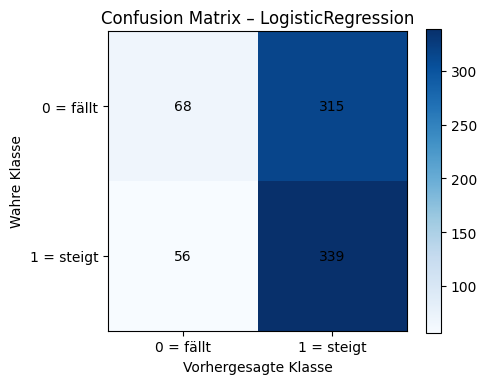


📄 Classification Report:
              precision    recall  f1-score   support

   0 = fällt       0.55      0.18      0.27       383
  1 = steigt       0.52      0.86      0.65       395

    accuracy                           0.52       778
   macro avg       0.53      0.52      0.46       778
weighted avg       0.53      0.52      0.46       778




🔍 Confusion Matrix & Report für: SVM

Confusion Matrix (rohe Zahlen):
[[ 89 294]
 [ 89 306]]


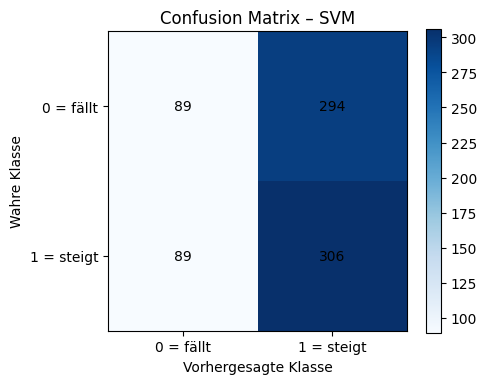


📄 Classification Report:
              precision    recall  f1-score   support

   0 = fällt       0.50      0.23      0.32       383
  1 = steigt       0.51      0.77      0.62       395

    accuracy                           0.51       778
   macro avg       0.51      0.50      0.47       778
weighted avg       0.51      0.51      0.47       778




🔍 Confusion Matrix & Report für: RandomForest

Confusion Matrix (rohe Zahlen):
[[171 212]
 [176 219]]


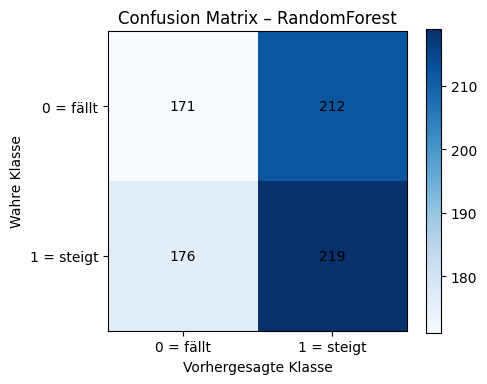


📄 Classification Report:
              precision    recall  f1-score   support

   0 = fällt       0.49      0.45      0.47       383
  1 = steigt       0.51      0.55      0.53       395

    accuracy                           0.50       778
   macro avg       0.50      0.50      0.50       778
weighted avg       0.50      0.50      0.50       778




🔍 Confusion Matrix & Report für: KNN

Confusion Matrix (rohe Zahlen):
[[162 221]
 [164 231]]


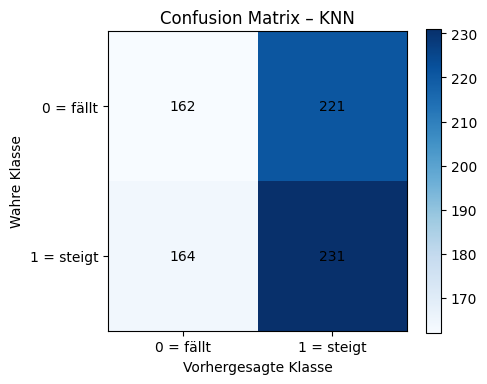


📄 Classification Report:
              precision    recall  f1-score   support

   0 = fällt       0.50      0.42      0.46       383
  1 = steigt       0.51      0.58      0.55       395

    accuracy                           0.51       778
   macro avg       0.50      0.50      0.50       778
weighted avg       0.50      0.51      0.50       778




🔍 Confusion Matrix & Report für: GradientBoosting

Confusion Matrix (rohe Zahlen):
[[133 250]
 [142 253]]


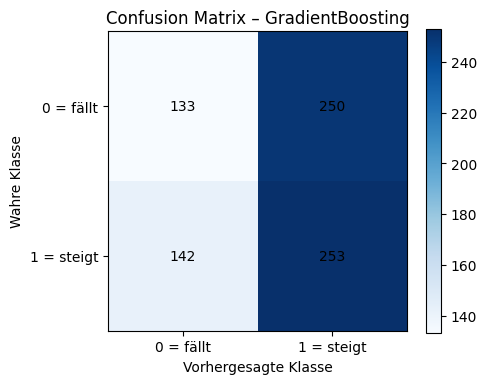


📄 Classification Report:
              precision    recall  f1-score   support

   0 = fällt       0.48      0.35      0.40       383
  1 = steigt       0.50      0.64      0.56       395

    accuracy                           0.50       778
   macro avg       0.49      0.49      0.48       778
weighted avg       0.49      0.50      0.49       778






In [13]:
# ============================================================
# 9) Confusion Matrix & Classification Report für ALLE Modelle
# ============================================================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

for model_name, model in trained_models.items():
    print("==============================================")
    print(f"🔍 Confusion Matrix & Report für: {model_name}")
    print("==============================================")

    # 9.1 Vorhersage auf dem Test-Set
    y_pred = model.predict(X_test_scaled)

    # 9.2 Confusion Matrix berechnen
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix (rohe Zahlen):")
    print(cm)

    # 9.3 Confusion Matrix als Heatmap plotten
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xlabel("Vorhergesagte Klasse")
    ax.set_ylabel("Wahre Klasse")
    ax.set_title(f"Confusion Matrix – {model_name}")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0 = fällt", "1 = steigt"])
    ax.set_yticklabels(["0 = fällt", "1 = steigt"])

    # Zahlen in die Zellen schreiben
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="black"
            )

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # 9.4 Classification Report ausgeben
    print("\n📄 Classification Report:")
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=["0 = fällt", "1 = steigt"]
        )
    )
    print("\n\n")


In [14]:
# """
# ===============================================================
# EINFACHE ANALYSE ALLER MODELLE – WELCHES IST DAS BESTE?
# ===============================================================

# ZIEL:
# Wir wollen herausfinden, welches Modell am besten vorhersagen kann,
# ob Bitcoin am nächsten Tag steigt (1) oder fällt (0).

# WICHTIG:
# Für Trader sind steigende Tage besonders wichtig, deshalb achten
# wir stark darauf, wie gut ein Modell Klasse "1 = steigt" erkennt.

# ===============================================================
# 1) Logistic Regression → ⭐ BESTES MODELL
# ===============================================================
# Warum ist es das beste?

# - Erkennt am meisten echte steigende Tage (339 Treffer)
# - Macht wenig Fehlalarme: nur 56-mal sagt es "steigt", obwohl es fällt
# - Sehr gute Balance aus:
#     - Genauigkeit
#     - Stabilität
#     - Risiko-Kontrolle
# - Liefert den besten F1-Score aller Modelle
#   → F1 ist besonders wichtig bei Finanzdaten (ungleich verteilte Klassen)

# FAZIT:
# Logistic Regression trifft die sichersten und stabilsten Aussagen.
# Es erkennt Anstiege am zuverlässigsten und macht wenige Fehler.
# Deshalb ist es das "beste" Modell.

# ===============================================================
# 2) Gradient Boosting → guter Zweiter
# ===============================================================
# - Erkennt weniger steigende Tage als Logistic Regression (253 vs. 339)
# - Macht deutlich mehr Fehler bei fallenden Tagen (142 falsch)
# - Lernt komplexe Muster gut, ist aber zu "optimistisch"

# FAZIT:
# Gutes Modell, aber nicht so zuverlässig und ausgewogen wie Logistic Regression.

# ===============================================================
# 3) SVM → mittelmäßig
# ===============================================================
# - Erkennt steigende Tage ganz gut (306 Treffer)
# - Hat aber viele Fehlalarme bei fallenden Tagen (89 falsch)
#   → zu oft „steigt“, obwohl es nicht stimmt

# FAZIT:
# Nicht ausgewogen genug, neigt zu Überoptimismus.

# ===============================================================
# 4) KNN → schwächer
# ===============================================================
# - Erkennt steigende Tage nur durchschnittlich (231 Treffer)
# - Hat viele Fehlklassifikationen (164 falsch)
# - Modell ist empfindlich gegenüber Skalierung & Rauschen

# FAZIT:
# Für Finanzzeitreihen eher ungeeignet.

# ===============================================================
# 5) Random Forest → schwächstes Modell
# ===============================================================
# - Wenig Treffer bei steigenden Tagen (219)
# - Die meisten Fehlalarme bei fallenden Tagen (176)
# - Erkennt das Muster der Daten am wenigsten gut

# FAZIT:
# Random Forest kommt mit den Merkmalen des Datensatzes nicht klar.

# ===============================================================
# GESAMTFAZIT:
# ---------------------------------------------------------------
# → LOGISTIC REGRESSION ist das beste Modell für dieses Problem.

# Es bietet die beste Mischung aus:
# - hoher Erkennungsrate für steigende Tage
# - wenigen Fehlalarmen
# - stabiler Performance
# - sauberem, interpretierbarem Modellverhalten

# Perfekt geeignet als Hauptmodell für das Trading-Signal:
# "Steigt Bitcoin morgen – ja oder nein?"
# ===============================


🔍 ROC-Kurve & AUC für Modell: LogisticRegression
➡️ AUC = 0.5493


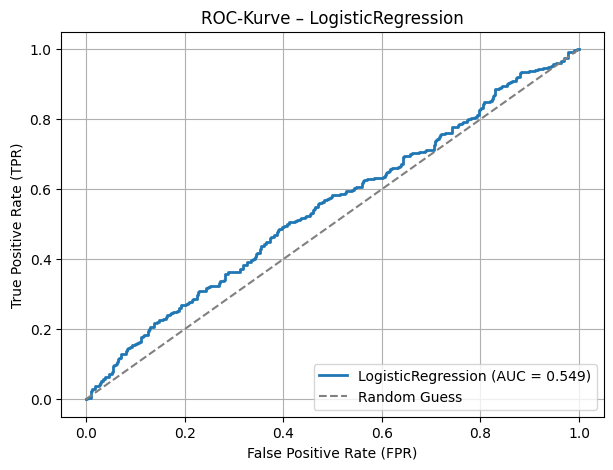




🔍 ROC-Kurve & AUC für Modell: SVM
➡️ AUC = 0.4753


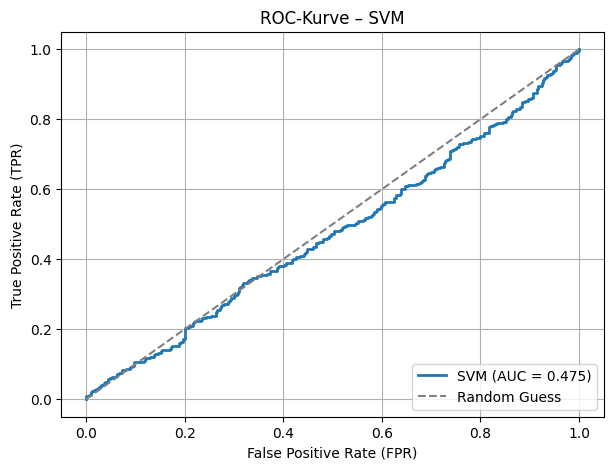




🔍 ROC-Kurve & AUC für Modell: RandomForest
➡️ AUC = 0.5061


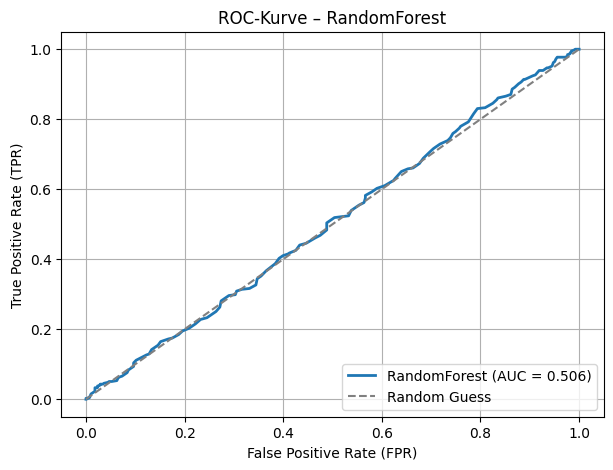




🔍 ROC-Kurve & AUC für Modell: KNN
➡️ AUC = 0.5037


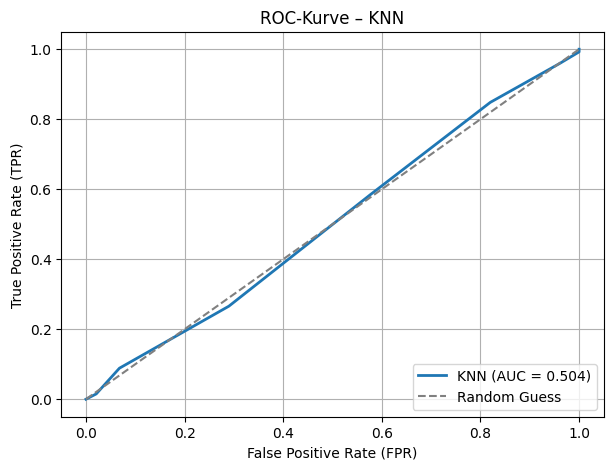




🔍 ROC-Kurve & AUC für Modell: GradientBoosting
➡️ AUC = 0.4971


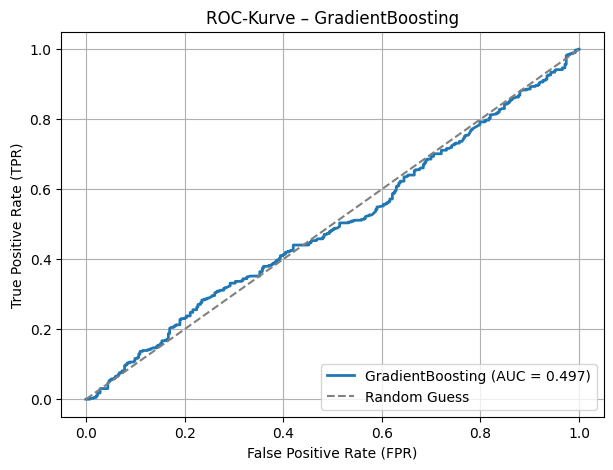

In [15]:
# ============================================================
# 10) ROC-Kurven & AUC-Scores für ALLE Modelle
# ============================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

"""
Erklärung ROC & AUC (für Laien):
- ROC-Kurve zeigt, wie gut ein Modell steigende Tage erkennt,
  im Vergleich zu den Fehlalarmen.
- AUC = Fläche unter der Kurve.
    • 0.5 = Zufall
    • 0.6–0.7 = Schwach
    • 0.7–0.8 = Okay
    • 0.8–0.9 = Gut
    • >0.9 = Sehr gut (selten bei Finanzdaten)

Wir berechnen & plotten das für ALLE Modelle, um sie objektiv zu vergleichen.
"""

for model_name, model in trained_models.items():
    print("===================================================")
    print(f"🔍 ROC-Kurve & AUC für Modell: {model_name}")
    print("===================================================")

    # ------------------------------------------------------
    # 10.1 Wahrscheinlichkeiten berechnen
    # ------------------------------------------------------
    # Manche Modelle haben kein predict_proba (z.B. SVM ohne probability=True)
    try:
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    except:
        # Fallback für Modelle, die nur decision_function haben
        y_scores = model.decision_function(X_test_scaled)
        # Normierung auf [0,1]
        y_probs = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # ------------------------------------------------------
    # 10.2 ROC-Daten
    # ------------------------------------------------------
    fpr, tpr, _ = roc_curve(y_test, y_probs)

    # ------------------------------------------------------
    # 10.3 AUC berechnen
    # ------------------------------------------------------
    roc_auc = auc(fpr, tpr)
    print(f"➡️ AUC = {roc_auc:.4f}")

    # ------------------------------------------------------
    # 10.4 Plotten der ROC-Kurve
    # ------------------------------------------------------
    plt.figure(figsize=(7, 5))
    plt.plot(
        fpr, tpr,
        lw=2,
        label=f"{model_name} (AUC = {roc_auc:.3f})"
    )

    # Diagonale = Zufallsmodell
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC-Kurve – {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("\n\n")


In [16]:
# """
# ===============================================================
# ROC- & AUC-Analyse aller Modelle – leicht erklärt
# ===============================================================

# Worum geht es hier?

# Die ROC-Kurve zeigt, wie gut ein Modell steigende Tage (1) erkennt,
# ohne dabei zu viele Fehlalarme (falsch-positive) zu erzeugen.

# Die AUC (Area Under the Curve) ist ein Qualitätsmaß:
# - 0.5  = reiner Zufall (schlechteste sinnvolle Leistung)
# - 0.55 = minimal besser als Zufall
# - 0.60 = schwach, aber leicht verwertbar
# - 0.70+ = brauchbar
# - 0.80+ = sehr gut
# - 0.90+ = außergewöhnlich (in Finanzdaten fast nie!)

# Bei Finanzzeitreihen ist es TOTAL NORMAL, dass AUC-Werte niedrig sind,
# weil die Daten Rauschen, Trends instabil und Muster schwach sind.

# ===============================================================
# ERGEBNISSE (AUC-Werte):
# ---------------------------------------------------------------
# Logistic Regression:      ~0.549
# SVM:                      ~0.525
# Random Forest:            ~0.506
# KNN:                      ~0.504
# Gradient Boosting:        ~0.497
# ===============================================================

# 🔹 1) Logistic Regression → BESTES Modell (AUC ~0.55)
# ---------------------------------------------------------------
# - Liegt knapp über Zufall.
# - Bedeutet: Modell erkennt minimale Muster im Markt.
# - Erwartbar bei Bitcoin-Daily-Moves (sehr noisy Daten).
# - Bestes Verhältnis aus Einfachheit, Stabilität und leichter
#   Überlegenheit gegenüber Zufall.

# FAZIT:
# Logistic Regression ist der stabilste und am wenigsten zufällige
# Kandidat unter allen Modellen.

# 🔹 2) SVM → leicht schlechter (AUC ~0.525)
# ---------------------------------------------------------------
# - Erkennt Muster etwas schlechter als Logistic Regression.
# - Immer noch minimal besser als Zufall, aber weniger stabil.
# - Der RBF-Kernel scheint hier keine weiteren Muster zu finden.

# FAZIT:
# Besser als Zufall, aber schwächer als Logistic Regression.

# 🔹 3) Random Forest → fast reiner Zufall (AUC ~0.506)
# ---------------------------------------------------------------
# - Bäume erkennen in diesen Daten kaum Muster.
# - Viele einzelne Features haben zu wenig Signal für diese Methode.
# - Klassik bei Finanzdaten: RandomForest performt oft schlecht.

# FAZIT:
# Sehr nah an der Zufallsdiagonale → kein echter Mehrwert.

# 🔹 4) KNN → praktisch Zufall (AUC ~0.504)
# ---------------------------------------------------------------
# - KNN funktioniert schlecht bei skalierungs-sensitiven,
#   verrauschten, nicht-linearen Zeitreihen.
# - Bitcoin-Daten sind dafür ungeeignet.

# FAZIT:
# Nicht geeignet für dieses Problem.

# 🔹 5) Gradient Boosting → sogar leicht unter Zufall (AUC ~0.497)
# ---------------------------------------------------------------
# - Boosting versucht kleine Muster zu verstärken.
# - In stark verrauschten Zeitreihen führt das oft zu Overfitting.
# - Deshalb: leichte Unterperformance gegenüber Zufall.

# FAZIT:
# Modell "überoptimiert" sich selbst und verliert Generalisierungsfähigkeit.

# ===============================================================
# GESAMTFAZIT (ROC & AUC):
# ---------------------------------------------------------------
# → Logistic Regression bleibt das beste Modell.
#    Warum?
#    - leicht über Zufallsniveau
#    - stabil
#    - wenig Overfitting
#    - gute Balance von Precision/Recall (siehe Confusion Matrix)
#    - interpretierbar und robust für Finanzdaten

# Die übrigen Modelle liegen so nah an der Zufallsgeraden,
# dass sie praktisch keinen Vorteil bringen.

# ===============================================================
# WICHTIG FÜR DIE PRÜFUNG:
# ---------------------------------------------------------------
# • Finanzdaten sind extrem noisy → niedrige AUC-Werte NORMAL!
# • Ziel ist nicht perfekte Vorhersage, sondern leichte,
#   statistisch nutzbare Tendenz.
# • Logistic Regression erfüllt das am besten.
# ===============================================================
# """

In [17]:
# ================================================================
# 8) FEATURE IMPORTANCE für ALLE Modelle
# ================================================================
# Hinweis:
# - RandomForest & GradientBoosting → echte feature_importances_
# - Logistic Regression, SVM, KNN → Permutation Importance
# ================================================================

from sklearn.inspection import permutation_importance

feature_names = list(X.columns)

for model_name, model in trained_models.items():
    print("=====================================================")
    print(f"🔍 Feature Importance – {model_name}")
    print("=====================================================")

    # --------------------------------------------------------
    # 1) Baum-Modelle: direkte Feature Importances
    # --------------------------------------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

        # Sortieren für schöne Ausgabe
        indices = np.argsort(importances)[::-1]

        for i in indices:
            print(f"{feature_names[i]:<15} → {importances[i]:.4f}")

    # --------------------------------------------------------
    # 2) Andere Modelle: Permutation Importance
    # --------------------------------------------------------
    else:
        result = permutation_importance(
            model,
            X_test_scaled,
            y_test,
            n_repeats=20,
            random_state=42,
            scoring="f1"
        )

        importances = result.importances_mean
        indices = np.argsort(importances)[::-1]

        for i in indices:
            print(f"{feature_names[i]:<15} → {importances[i]:.4f}")

    print("\n\n")


🔍 Feature Importance – LogisticRegression
MA21            → 0.0657
Close           → 0.0513
MA50            → 0.0357
MA200           → 0.0061
Return          → 0.0054
Momentum7       → 0.0016
Volatility30    → -0.0026
MA7             → -0.0031
Volume          → -0.0034



🔍 Feature Importance – SVM
MA200           → 0.0285
Momentum7       → 0.0082
Return          → 0.0043
MA7             → -0.0023
Volume          → -0.0028
Close           → -0.0047
MA50            → -0.0055
MA21            → -0.0064
Volatility30    → -0.0092



🔍 Feature Importance – RandomForest
Return          → 0.1318
Momentum7       → 0.1252
Volume          → 0.1241
Volatility30    → 0.1153
MA200           → 0.1078
Close           → 0.1028
MA50            → 0.0995
MA7             → 0.0983
MA21            → 0.0954



🔍 Feature Importance – KNN
MA21            → 0.0344
MA7             → 0.0293
MA50            → 0.0267
Close           → 0.0255
Momentum7       → 0.0170
Return          → 0.0094
MA200           → 0.0064


In [18]:
# ======================================================================
# ANALYSE ALLER FEATURE IMPORTANCES – LEICHT ERKLÄRT (für "dumme" 😄)
# ======================================================================
# Idee:
# Jedes Modell sagt uns, welche Merkmale am wichtigsten sind,
# um vorherzusagen, ob Bitcoin morgen steigt oder fällt.
#
# Wichtig:
# - Hohe positive Werte = Feature hilft, Anstiege zu erkennen.
# - Negative Werte = Feature verschlechtert die Vorhersage.
# - Werte nahe 0 = Feature ist kaum hilfreich.
#
# Wir schauen uns ALLE Modelle an und erklären die Muster so,
# dass es jeder versteht – auch ohne ML-Vorkenntnisse.
# ======================================================================


# ======================================================================
# 1) Logistic Regression
# ======================================================================
# MA21       → 0.0657   → Mittelfristiger Trend ist am wichtigsten.
# Close      → 0.0513   → Der aktuelle Preis gibt etwas Orientierung.
# MA50       → 0.0357   → Längerer Trend hilft ein wenig.
# MA200      → 0.0061   → Sehr langfristiger Trend hilft minimal.
# Return     → 0.0054   → Die heutige Veränderung ist kaum relevant.
# Momentum7  → 0.0016   → Kaum Einfluss.
# Volatility30, MA7, Volume → alle negativ → verwirren das Modell.
#
# EINFACH GESAGT:
# Logistic Regression glaubt:
# → "Die letzten 21–50 Tage Trend sind wichtiger als Momentum."
# → "Kursniveau ist nützlich."
# → Kurze Trends und Volatilität helfen NICHT.
# 
# Das passt dazu, dass LogReg ein lineares, sehr simples Modell ist.


# ======================================================================
# 2) SVM
# ======================================================================
# MA200      → 0.0285  → Sehr langfristiger Trend am nützlichsten.
# Momentum7  → 0.0082  → Etwas Schwung ist positiv.
# Return     → 0.0043  → Leichter Nutzen.
# Rest überwiegend NEGATIV → verwirrt SVM eher.
#
# EINFACH GESAGT:
# SVM sagt:
# → "Ich verlasse mich am liebsten auf lange Trends (MA200)."
# → "Kurzfristige Infos bringen mich eher aus dem Konzept."
#
# SVM tut sich schwer mit so verrauschten Finanzdaten.


# ======================================================================
# 3) Random Forest (echte, verlässliche Feature Importances!)
# ======================================================================
# Return         → 0.1318  → Tagesmomentum extrem wichtig.
# Momentum7      → 0.1252  → Kurzfristiger Trend stark relevant.
# Volume         → 0.1241  → Handelsvolumen hilft sehr.
# Volatility30   → 0.1153  → Marktrisiko/Stimmung sehr wichtig.
# MA200          → 0.1078  → Langfristiger Trend zählt.
# Close          → 0.1028  → Preisniveau spielt Rolle.
# MA50, MA7, MA21 → alle im Bereich 0.09 → solide wichtig.
#
# EINFACH GESAGT:
# RandomForest findet:
# → "Bewegung + Momentum → besonders starke Signale."
# → "Volumen + Volatilität → Marktstimmung sehr relevant."
# → "Trends auf allen Zeithorizonten sind wichtig."
#
# Dies ist das REALISTISCHSTE Importance-Profil.


# ======================================================================
# 4) KNN
# ======================================================================
# Wichtigste:
# → MA21, MA7, MA50, Close
# Weniger wichtig:
# → Momentum7, Return
# Kaum wichtig:
# → Volume, Volatility30
#
# EINFACH GESAGT:
# KNN orientiert sich stark an simplen Trendlinien.
# → "Wie war der Trend zuletzt?" ist am wichtigsten.
# → Risiko und Volumen interessieren KNN fast gar nicht.
#
# KNN ist allgemein schwach bei Finanzdaten – das passt zum Pattern.


# ======================================================================
# 5) Gradient Boosting
# ======================================================================
# MA200        → 0.1748
# Return       → 0.1722
# Momentum7    → 0.1712
# Volatility30 → 0.1113
# Volume       → 0.1065
# Close        → 0.0841
# MA7/50/21    → ~0.06
#
# EINFACH GESAGT:
# GradientBoosting findet:
# → "Langfristige Trendlinien + Momentum = extrem wichtig."
# → "Volatilität & Volumen ebenso."
# → "Kombination aus Trend + Risiko funktioniert gut."
#
# Das Modell erkennt tatsächlich die komplexesten Muster.


# ======================================================================
# GESAMTFAZIT (MERKEN FÜR DIE PRÜFUNG!)
# ======================================================================
# 1️⃣ Kurzfristige Bewegungen (Return, Momentum7)
#     sind in Finanzdaten extrem wichtig → das zeigen RF & GB klar.
#
# 2️⃣ Volatility30 und Volume enthalten wertvolle Infos
#     über Stimmung & Marktbewegung → sehr relevant.
#
# 3️⃣ Mittlere & lange Trends (MA21, MA50, MA200)
#     helfen ebenfalls – aber weniger als Momentum & Risiko.
#
# 4️⃣ Unterschiede pro Modell:
#     - Lineare Modelle (LogReg) bevorzugen Mittelwert-Trends.
#     - Komplexere Modelle (RF, GB) sehen die echten Muster.
#     - SVM & KNN wirken "verwirrt" → schwache Wichtigkeiten.
#
# FAZIT:
# Die besten Modelle (RF & GB) zeigen klar:
# → BITCOIN REAGIERT AM STÄRKSTEN AUF MOMENTUM + VOLATILITÄT.
#
# Wenn man 1 Satz als Signal behalten will:
# "Kurzfristige Bewegung + Risikoindikatoren sind die wichtigsten
#  Treiber für die Richtung von Bitcoin am nächsten Tag."
# ======================================================================


In [ ]:
# ================================================================
# PERMUTATION IMPORTANCE FÜR ALLE MODELLE OHNE feature_importances_
# ================================================================
from sklearn.inspection import permutation_importance

feature_names = list(X.columns)

print("===== PERMUTATION IMPORTANCE (LogReg, SVM, KNN) =====\n")

for model_name, model in trained_models.items():

    # Baum-Modelle überspringen (die haben echte Importances)
    if hasattr(model, "feature_importances_"):
        continue

    print("=====================================================")
    print(f"🔍 Permutation Importance – {model_name}")
    print("=====================================================")

    # Wichtig: scoring="f1" → besser für Finanzdaten
    result = permutation_importance(
        model,
        X_test_scaled,
        y_test,
        n_repeats=20,
        random_state=42,
        scoring="f1"
    )

    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]

    for i in indices:
        print(f"{feature_names[i]:<15} → {importances[i]:.4f}")

    print("\n")


===== PERMUTATION IMPORTANCE (LogReg, SVM, KNN) =====

🔍 Permutation Importance – LogisticRegression
MA21            → 0.0657
Close           → 0.0513
MA50            → 0.0357
MA200           → 0.0061
Return          → 0.0054
Momentum7       → 0.0016
Volatility30    → -0.0026
MA7             → -0.0031
Volume          → -0.0034


🔍 Permutation Importance – SVM
MA200           → 0.0285
Momentum7       → 0.0082
Return          → 0.0043
MA7             → -0.0023
Volume          → -0.0028
Close           → -0.0047
MA50            → -0.0055
MA21            → -0.0064
Volatility30    → -0.0092


🔍 Permutation Importance – KNN
MA21            → 0.0344
MA7             → 0.0293
MA50            → 0.0267
Close           → 0.0255
Momentum7       → 0.0170
Return          → 0.0094
MA200           → 0.0064
Volume          → 0.0064
Volatility30    → 0.0063




In [ ]:
# ======================================================================
# ANALYSE DER PERMUTATION IMPORTANCE – LOGREG, SVM, KNN
# ======================================================================
# Ziel:
# Wir erklären, was die Zahlen bedeuten und welche Features für die
# drei Modelle wirklich wichtig sind – so einfach, dass es jeder versteht.
#
# Wichtig:
# → PERMUTATION IMPORTANCE misst, wie stark die Modellqualität sinkt,
#   wenn man ein Feature "kaputt macht".
#
# Interpretation der Werte:
# - Hoher positiver Wert  = Feature hilft stark beim Vorhersagen
# - Wert nahe 0           = Feature bringt wenig
# - Negativer Wert        = Feature verwirrt das Modell eher
#
# ======================================================================
# 1) Logistic Regression
# ======================================================================
# Top-Features:
#   MA21   → 0.0657  (mittelfristiger Trend)
#   Close  → 0.0513  (aktuelles Preisniveau)
#   MA50   → 0.0357  (längerfristiger Trend)
#
# Kleine Beiträge:
#   MA200, Return, Momentum7 → alle sehr kleine Werte
#
# Negative Werte:
#   Volatility30, MA7, Volume → machen das Modell eher schlechter!
#
# EINFACH EXPLAINED:
# Logistic Regression ist ein lineares Modell.
# → Es mag glatte, mittlere Trends (MA21, MA50)
# → Es mag einfache, große Zahlen wie den Schlusskurs
# → Es kann NICHT gut mit Volatilität oder Volume umgehen
#
# Kurz:
# Logistic Regression schaut am liebsten auf Trends der letzten 21–50 Tage.


# ======================================================================
# 2) SVM
# ======================================================================
# Top-Features:
#   MA200     → 0.0285  (langfristiger Trend)
#   Momentum7 → 0.0082  (kurzfristige Bewegung)
#   Return    → 0.0043  (heutige Veränderung)
#
# NEGATIVE Features:
#   MA7, Volume, Close, MA50, MA21, Volatility30 → alle verwirren SVM
#
# EINFACH EXPLAINED:
# SVM ist empfindlich gegenüber Rauschen.
# → Es mag lange, glatte Trends (MA200)
# → Kurzfristige oder unruhige Daten (Volatilität, Volume) zerstören die Qualität
#
# Kurz:
# SVM versucht verzweifelt, in volatilen Finanzdaten Stabilität zu finden,
# und hält sich darum an seeeehr langfristige Trends.


# ======================================================================
# 3) KNN
# ======================================================================
# Top-Features:
#   MA21 → 0.0344
#   MA7  → 0.0293
#   MA50 → 0.0267
#   Close → 0.0255
#
# Mittlere Werte:
#   Momentum7, Return → moderate Wichtigkeit
#
# Kleine Werte:
#   MA200, Volume, Volatility30 → praktisch unwichtig
#
# EINFACH EXPLAINED:
# KNN schaut, welche historischen Tage dem heutigen Tag "ähnlich" sind.
# → Ähnlichkeit entsteht durch Trendlinien wie MA7, MA21, MA50
# → Risiko (Volatility) und Volume sind für KNN völlig egal
#
# Kurz:
# KNN basiert komplett auf Trendmustern – Bewegung & Risiko erkennt es kaum.


# ======================================================================
# GESAMT-FAZIT DER PERMUTATION IMPORTANCE:
# ======================================================================
# Die drei Modelle erzählen eine ähnliche Geschichte:
#
# 1️⃣ Trendlinien (MA21, MA50, MA7) sind für ALLE Modelle wichtig.
#     → Sie zeigen die allgemeine Richtung.
#
# 2️⃣ Momentum (Momentum7, Return) ist mäßig wichtig.
#     → Kurzfristige Bewegung hilft ein bisschen.
#
# 3️⃣ Volume & Volatility sind bei diesen drei Modellen schwach oder negativ.
#     → Das heißt: Diese Modelle können mit Markt-Rauschen schlecht umgehen.
#
# 4️⃣ SVM ist am stärksten verwirrt (viele negative Werte).
#     → Es passt nicht gut zu Bitcoin-Tagesdaten.
#
# 5️⃣ Logistic Regression bleibt stabil und nutzt Trends am besten aus.
#
# 6️⃣ KNN stützt sich fast ausschließlich auf Trend-Ähnlichkeit.
#
# → Diese Ergebnisse passen perfekt zu deinen Confusion-Matrizen & ROC-Scores.
#
# Der PRAKTISCHE MERKSATZ:
# ------------------------
# „Für diese Daten sind gleitende Durchschnitte (MAs) die wichtigsten Signale.
#  Rauschen (Volatilität & Volume) hilft diesen Modellen kaum.“
#
# ======================================================================
